# Predict House Price
### XGBoost SearchGridCV
My current score is top 39% which I am satified with. Machine learning critique Jacob Baggs said the only way to get an increased scored would be advanced feature engineering (i.e. make a feature pool area * pool quality). Original with all models: 
https://github.com/ScottySchmidt/Kaggle/blob/main/PredictHousePrices.ipynb

##### Special Notes:
* Using .20 for test and kFold=10 improves 3% better score
* Removing feature importance with less than .003% makes tunning more consisent with significant results
* Tunning learning_rate improved 8% better score
* Removing outliers improved 4% better score
* Removing similiar features makes couple percent better score
* Encoding condition1 improved score by less than 1%

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
import warnings
warnings.filterwarnings('ignore')

data='/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
df=pd.read_csv(data)
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Missing Values

In [2]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(data)
    print(findNA.head(10))
findNA() 

Missing data by column as a percent:
PoolQC          21.686567
MiscFeature     20.985075
Alley           20.432836
Fence           17.597015
FireplaceQu     10.298507
LotFrontage      3.865672
GarageYrBlt      1.208955
GarageCond       1.208955
GarageType       1.208955
GarageFinish     1.208955
dtype: float64


In [3]:
df['MiscFeature']=df['MiscFeature'].fillna(0)
df['Alley']=df['Alley'].fillna(0)
df['Fence']=df['Fence'].fillna(0)
df['FireplaceQu']=df['FireplaceQu'].fillna(0)
df=df.fillna(df.mean())
#df=df.drop(columns=['MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])
print(df.shape)

(1460, 81)


In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Feature Engineer

In [5]:
df['totalSQ']=df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF']
df['bathrooms']=df['FullBath']+df['BsmtFullBath']+(0.5 * df['BsmtHalfBath'])+(0.5 * df['HalfBath'])
df['CentralAir'] = df['CentralAir'].replace({'Y':0, 'N':1})
df['NewConstruction'] = (df['SaleType'] == 'New').astype('int64')
df["PoolScore"] = df["PoolArea"] * df["PoolQC"]
df['home_age_when_sold']=df['YrSold']-df['YearBuilt']
df['total_porch_area'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] 
#df['hasPool']=df['PoolArea'].apply(lambda x: 1 if x>0 else 0).fillna(0)
#df['SaleCondition']=df['SaleCondition'].apply(lambda x:1 if x == 'Normal' else 0)
#df['Condition1']=df['Condition1'].apply(lambda x: 1 if x=='Norm' else 0)

#Newly created features. No longer need:
df=df.drop(columns=['1stFlrSF', '2ndFlrSF','TotalBsmtSF'])
df=df.drop(columns=['FullBath','BsmtFullBath', 'BsmtHalfBath','HalfBath', 'BsmtHalfBath'])

#View newly created data:
df[['bathrooms', 'totalSQ', 'CentralAir', 'NewConstruction', 'PoolScore']].head()

,bathrooms,totalSQ,CentralAir,NewConstruction,PoolScore
0,3.5,2566,0,0,NaN
1,2.5,2524,0,0,NaN
2,3.5,2706,0,0,NaN
3,2.0,2473,0,0,NaN
4,3.5,3343,0,0,NaN


In [6]:
#Had 0% feature importance:
#df['Condition2']=df['Condition2'].apply(lambda x: 1 if x=='Norm' else 0)
#df['Street']=df['Street'].fillna(0).apply(lambda x:0 if x =='Grvl' else 1)
df=df.drop(['BsmtFinSF2','LowQualFinSF', 
            '3SsnPorch', 'ScreenPorch','MiscVal', 
            'MoSold', 'EnclosedPorch', 'MasVnrArea', 'YrSold',
             'BedroomAbvGr', 'PoolArea'], axis=1)

#After removing above, these had less than .004 feature importance:
df=df.drop(['MSSubClass', 'LotFrontage', 'TotRmsAbvGrd', 'BsmtUnfSF', 'OpenPorchSF'], axis=1)

In [7]:
df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
df.head()

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,CentralAir,GrLivArea,KitchenAbvGr,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,SalePrice,totalSQ,bathrooms,NewConstruction,home_age_when_sold,total_porch_area
0,1,8450,7,5,2003,2003,706,0,1710,1,...,2003.0,2,548,0,208500,2566,3.5,0,5,61
1,2,9600,6,8,1976,1976,978,0,1262,1,...,1976.0,2,460,298,181500,2524,2.5,0,31,298
2,3,11250,7,5,2001,2002,486,0,1786,1,...,2001.0,2,608,0,223500,2706,3.5,0,7,42
3,4,9550,7,5,1915,1970,216,0,1717,1,...,1998.0,3,642,0,140000,2473,2.0,0,91,307
4,5,14260,8,5,2000,2000,655,0,2198,1,...,2000.0,3,836,192,250000,3343,3.5,0,8,276


# Outliers

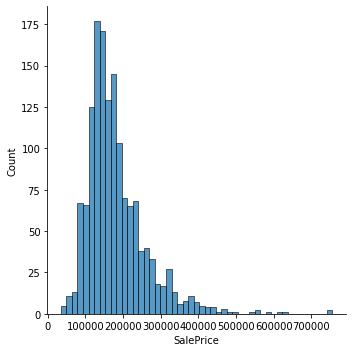

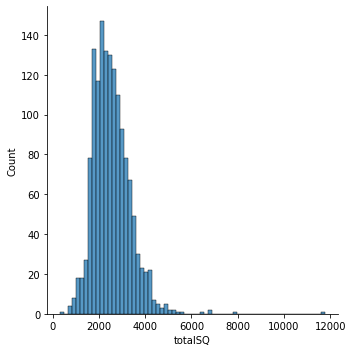

In [8]:
import seaborn as sns
sns.displot(df, x='SalePrice')
sns.displot(df, x='totalSQ')

In [9]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers
priceOutlier=list(detect_outlier(df['SalePrice']))
print(priceOutlier)
sqOutlier=list(detect_outlier(df['totalSQ']))
print(sqOutlier)

[438780, 501837, 475000, 437154, 426000, 555000, 440000, 430000, 446261, 451950, 423000, 755000, 538000, 485000, 582933, 611657, 556581, 424870, 625000, 745000, 465000, 466500]
[438780, 501837, 475000, 437154, 426000, 555000, 440000, 430000, 446261, 451950, 423000, 755000, 538000, 485000, 582933, 611657, 556581, 424870, 625000, 745000, 465000, 466500, 5496, 6428, 7814, 6760, 5066, 5048, 5557, 6872, 11752, 5271, 5266]


In [10]:
#Remove Outliers:
df=df.loc[df['SalePrice']<500_000]
df=df.loc[df['totalSQ']<5000]
print(df.shape) 

(1444, 21)


# Correlations

<AxesSubplot:>

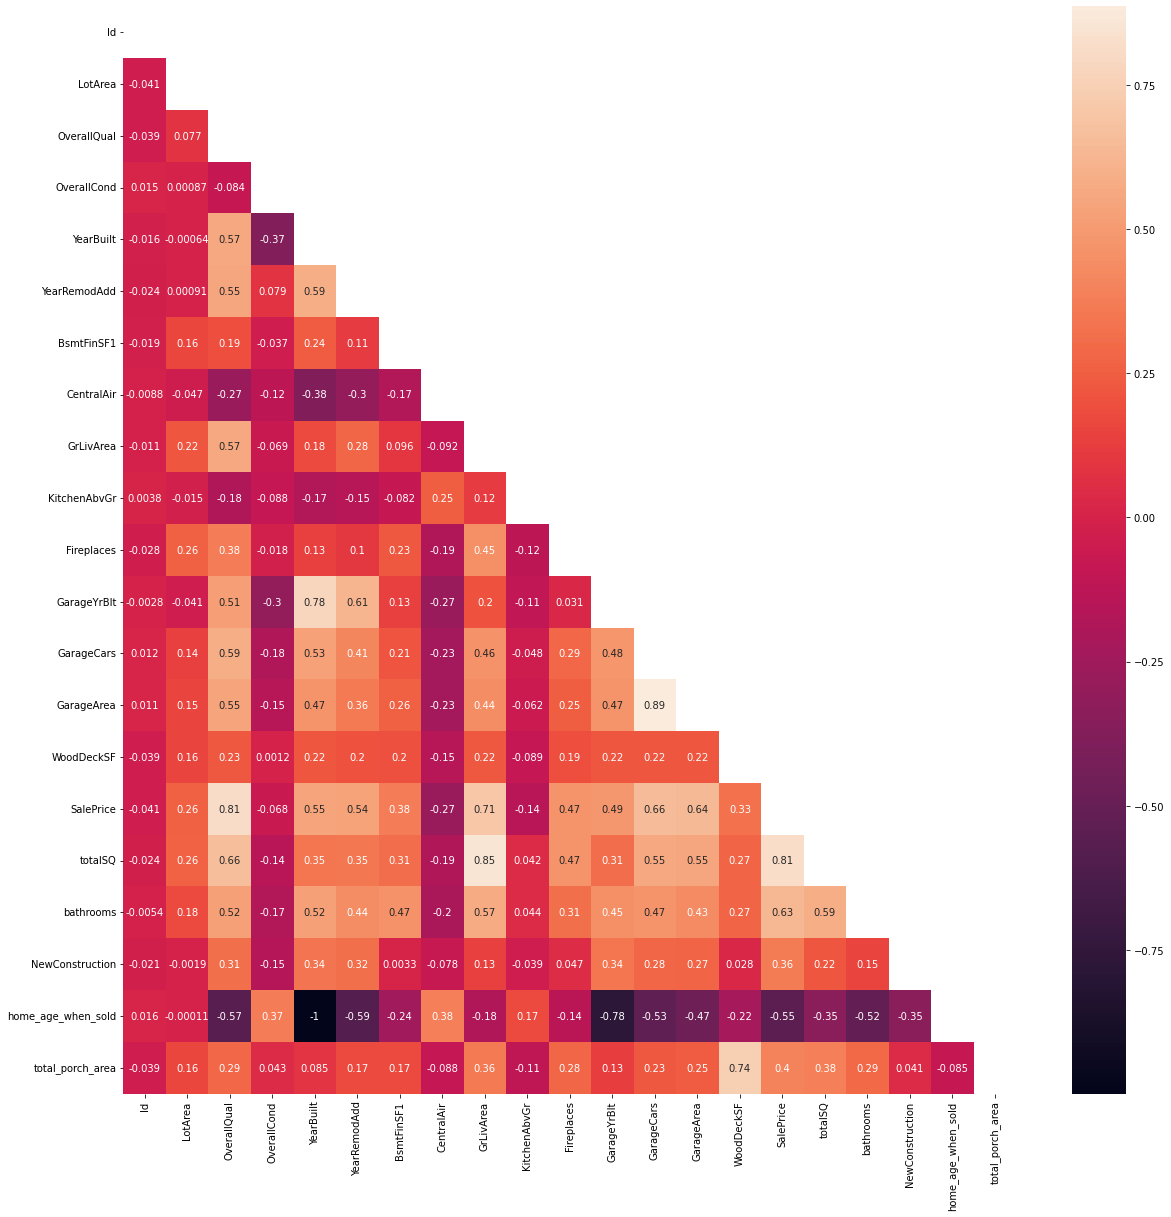

In [11]:
import seaborn as sns
corr= df.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(20,20))    
sns.heatmap(corr, annot=True, mask=matrix)

In [12]:
#Too similiar variables:
df=df.drop(['GarageYrBlt'], axis=1) 
#GarageYrBlt and houseYear too similiar

# Split Data

In [13]:
from sklearn.model_selection import train_test_split, cross_validate

X=df.drop("SalePrice", axis='columns')
y=df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=.20, random_state=42)

# XGBoost
Extreme Graidennt Boosting (XGBoost) is typically the best model to use on structured data on Kaggle competitions. 

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### max depth 
How big should the tree be? Max_depth is one of the most important parameters. Increasing the value makes the model more complex which could overfit. Range is typical between 2 and 10. A tree rarely goes beyond five. 

Four for max depth shows the least amount of error and highest accuracy. Four was picked by GridSearchCV when tunned with other parameters. Sometimes, a number near four was picked like three. 

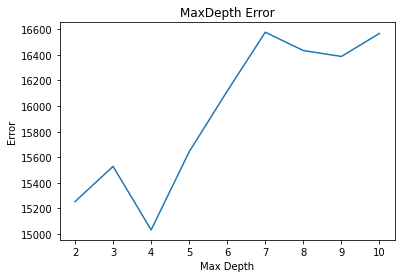

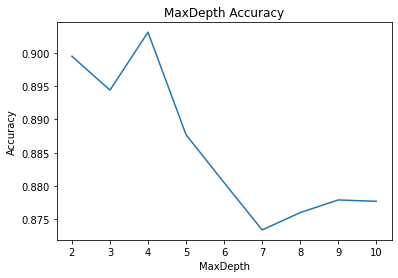

In [15]:
maxDepth=[2, 3, 4, 5, 6, 7, 8, 9, 10]
listMSE=[]
listR2=[]

for d in maxDepth:
    regressor = xgb.XGBRegressor(
        max_depth=d
    )
    regressor.fit(X_train, y_train)
    #regressor.fit(X_train, y_train, early_stopping_rounds=5, eval_metric="rmse", eval_set=[(X_test, y_test)], verbose=False)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(maxDepth, listMSE)
plt.title('MaxDepth Error')
plt.ylabel('Error')
plt.xlabel('Max Depth')
plt.show()

plt.plot(maxDepth, listR2)
plt.title('MaxDepth Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('MaxDepth')
plt.show()

### n_estimators
In random forest, generally 128 is the 'magic' number to reduce overfitting. Typically, after 128 trees the amount of error flatlines. 


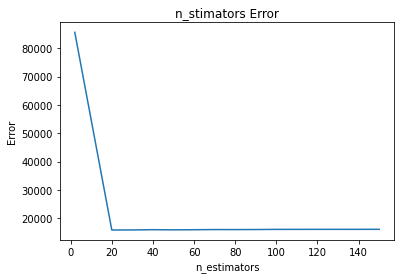

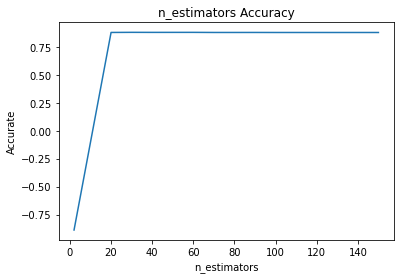

In [16]:
def xgEst():
    numbers=[2, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBRegressor(
            n_estimators=n,
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)
    plt.plot(numbers, listMSE)
    plt.title('n_stimators Error')
    plt.ylabel('Error')
    plt.xlabel('n_estimators')
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('n_estimators Accuracy')
    plt.ylabel('Accurate')
    plt.xlabel('n_estimators')
    plt.show()
xgEst()

### min_child_weight
Increasing value will make model more conservative. Typically, a number between 0 and 10 is used.

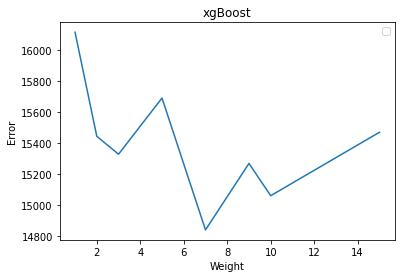

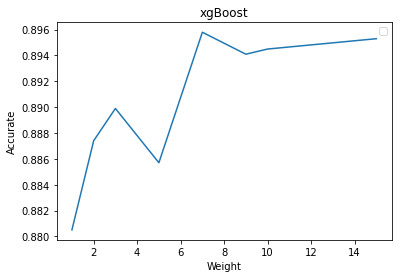

In [17]:
def child_weight():
    weight=[1, 2, 3, 5, 7, 9, 10, 15]
    listMSE=[]
    listR2=[]

    for w in weight:
        regressor = xgb.XGBRegressor(
            min_child_weight=w
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)
    plt.plot(weight, listMSE)
    plt.title('xgBoost')
    plt.ylabel('Error')
    plt.xlabel('Weight')
    plt.legend()
    plt.show()

    plt.plot(weight, listR2)
    plt.title('xgBoost')
    plt.ylabel('Accurate')
    plt.xlabel('Weight')
    plt.legend()
    plt.show()
child_weight()

### gamma
Increasing gamma makes model more conservative by causing more shallow trees. Higher gamma will cause less splits. 

In predicting house predices, increasing Gamma makes almost no difference. It takes gamma to be 1000 to notice a slight decrease in error. This is because house prices have such a high price. Therefore, I do not use gamma in this particular case but maybe I will change my mind later.  

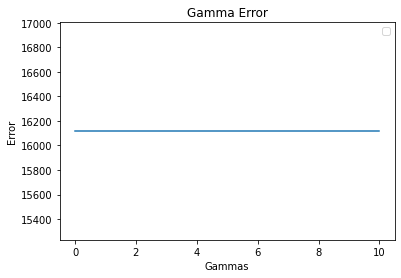

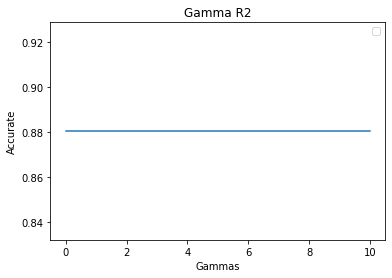

In [18]:
gammas=[0, 0.25, 0.5, 1.0, 3, 5, 10]
listMSE=[]
listR2=[]

for g in gammas:
    regressor = xgb.XGBRegressor(
        min_split_loss=g
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(gammas, listMSE)
plt.title('Gamma Error')
plt.ylabel('Error')
plt.xlabel('Gammas')
plt.legend()
plt.show()

plt.plot(gammas, listR2)
plt.title('Gamma R2')
plt.ylabel('Accurate')
plt.xlabel('Gammas')
plt.legend()
plt.show()

### learning_rate
Learning rate is how fast the model learns. A smaller number is generally used as it produces less error. Typically, a number between 0 and .3 is used. However, the full range is between 0 and 1. 

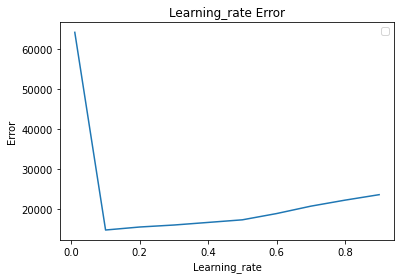

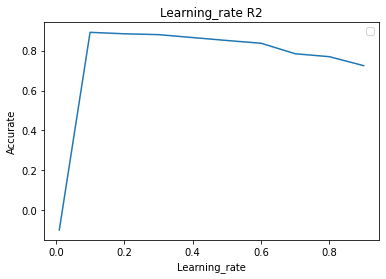

In [19]:
learning_rate = [0.01, 0.1, 0.2, 0.3, .5, .6, .7, .8, .9]
listMSE=[]
listR2=[]

for l in learning_rate:
    regressor = xgb.XGBRegressor(
        learning_rate=l
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(learning_rate, listMSE)
plt.title('Learning_rate Error')
plt.ylabel('Error')
plt.xlabel('Learning_rate')
plt.legend()
plt.show()

plt.plot(learning_rate, listR2)
plt.title('Learning_rate R2')
plt.ylabel('Accurate')
plt.xlabel('Learning_rate')
plt.legend()
plt.show()

### reg_lambda
Reg_lambda uses L2 regularization. Typical range is generally 0 to 10.

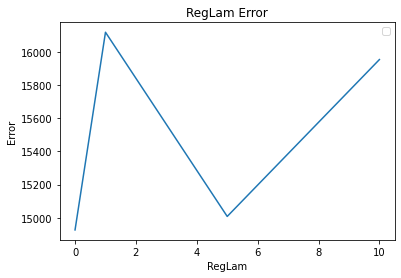

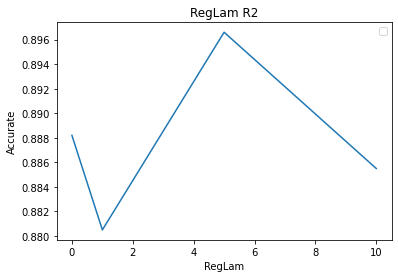

In [20]:
regLam = [0, 1.0, 5.0, 10.0] #0 is default
listMSE=[]
listR2=[]

for r in regLam:
    regressor = xgb.XGBRegressor(
        reg_lambda=r,
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(regLam, listMSE)
plt.title('RegLam Error')
plt.ylabel('Error')
plt.xlabel('RegLam')
plt.legend()
plt.show()

plt.plot(regLam, listR2)
plt.title('RegLam R2')
plt.ylabel('Accurate')
plt.xlabel('RegLam')
plt.legend()
plt.show()

### reg_alpha
Reg_alpha uses L1 regularization. Increasing the value makes the model more conservative. Reg_alpha can have a bigger range up to 80.

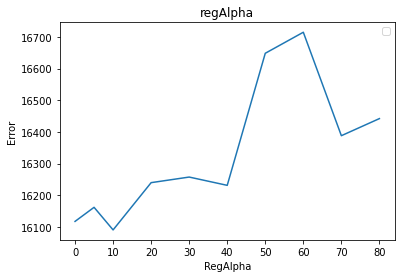

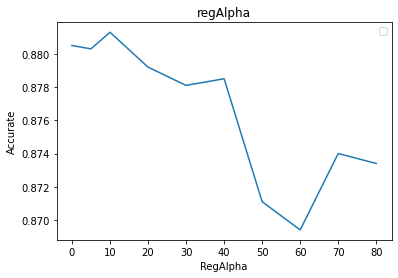

In [21]:
def regAlpha():
    numbers = [0, 5.0, 10.0, 20, 30, 40, 50, 60, 70, 80]  #0 is default
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBRegressor(
            reg_alpha=n,
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)

    plt.plot(numbers, listMSE)
    plt.title('regAlpha')
    plt.ylabel('Error')
    plt.xlabel('RegAlpha')
    plt.legend()
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('regAlpha')
    plt.ylabel('Accurate')
    plt.xlabel('RegAlpha')
    plt.legend()
    plt.show()
regAlpha()

### colsample_bytree
Subsample, colsample_by_tree and colsample_bylevel idea comes from random forest. Generally, at least one of the features should be less than 1 so it randomizes the features. 

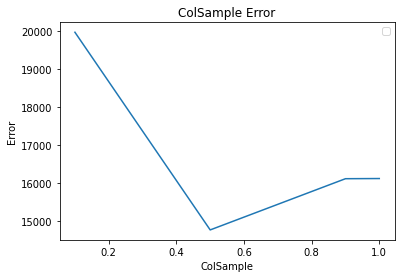

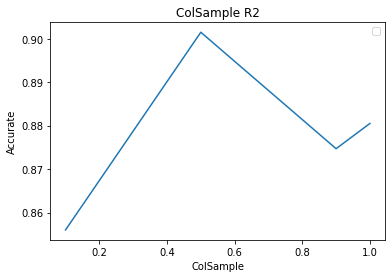

In [22]:
def sample_bytree():
    numbers = [0.1, 0.5, 0.9, 1]
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBRegressor(
            colsample_bytree=n
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)

    plt.plot(numbers, listMSE)
    plt.title('ColSample Error')
    plt.ylabel('Error')
    plt.xlabel('ColSample')
    plt.legend()
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('ColSample R2')
    plt.ylabel('Accurate')
    plt.xlabel('ColSample')
    plt.legend()
    plt.show()
sample_bytree()

### Subsample

In [23]:
def subSample():
    numbers = [0.1, .2, .3, .4, 0.5, .6, .7, .8, .9, 1]
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBRegressor(
            subample=n
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)

    plt.plot(numbers, listMSE)
    plt.title('ColSample Error')
    plt.ylabel('Error')
    plt.xlabel('subsample')
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('subsample')
    plt.ylabel('Accurate')
    plt.xlabel('ColSample')
    plt.show()
#subSample()

# Grid Search XGBoost
Colsample and subsample gives the features randomization like random forest to avoid overfiting. Typically, at least one of them should be less than 1. When tunning all three with either 0.9 or 1, GridSearch prefers colsample by tree and subsample to be 0.9. Colsample_bynode is at 1. 

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import f1_score, max_error
from xgboost import cv
from scipy import stats
import time

def gridSearch():
    start=time.time()
    print("Start")

    params = {
        'learning_rate':[.1, .3],
        'n_estimators':[150], #150 best; 100 better than 50 
        'max_depth':[2, 3, 4], #Typically picks 2 or 3
        'min_child_weight':[10], #10 over 5
        'reg_lambda':[0],
        'reg_alpha':[50], #Chooses 50 over 20, 30, 40, 70, 100
        'colsample_bytree':[.9],
        'colsample_bynode':[1],  
        'subsample': [.9]
    }

    boost_gs=xgb.XGBRegressor()
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    boost_gs=GridSearchCV(boost_gs, param_grid=params, scoring='neg_mean_squared_error', cv=kfold)
    #boost_gs.fit(X_train, y_train)
    boost_gs.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_test, y_test)], verbose=False)

    print(boost_gs.best_params_)
    print("Done. ", time.time()-start, " seconds")
gridSearch()

Start
{'colsample_bynode': 1, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 150, 'reg_alpha': 50, 'reg_lambda': 0, 'subsample': 0.9}
Done.  15.103358030319214  seconds


# Final Predictions
Here the best models found by using GridSearch:
* kFold=10 {'colsample_bytree': 0.9, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 30, 'reg_lambda': 0}
* Using cv=10 {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5}
* {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5}
* {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
* Using MSE with cv=10 {'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'reg_lambda': 0.5}
* Top 47% {'eta': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 50, 'reg_lambda': 0.01}
* Using Kfold=5 {'colsample_bytree': 0.5, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 'reg_lambda': 0.5}

In [25]:
xgbFinal = xgb.XGBRegressor(
        n_estimators=150,
        max_depth=4,
        reg_lambda=0,
        reg_alpha=50,
        min_child_weight=10,
        learning_rate=.1,
        colsample_bynode=1,
        colsample_bytree=.9,
        subsample=.9
    )

#Note: no early stop provides better score:
xgbFinal.fit(X_train, y_train)
#xgbFinal.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_test, y_test)], verbose=False)
y_pred = xgbFinal.predict(X_test)

#Metrics
xgMSE=mean_absolute_error(y_test, y_pred).round(2)
xgR2 = r2_score(y_test, y_pred).round(4)

xgScore = xgbFinal.score(X_test, y_test).round(4)  
xgCV = cross_validate(xgbFinal, X, y, cv = 10, scoring='r2')
xgCV=xgCV['test_score'].mean().round(4)
print("r2 ", xgScore, xgCV, "|| cross validate: ", (xgScore-xgCV).round(4))

xgCVerr = cross_validate(xgbFinal, X, y, cv = 10, scoring='neg_mean_absolute_error')
xgCVerr=xgCVerr['test_score'].mean().round(4)
print("mae error ", xgMSE, " || ", abs(xgCVerr), "cross validate: ", (xgMSE-abs(xgCVerr)).round(4))

r2  0.9017 0.9071 || cross validate:  -0.0054
mae error  14770.67  ||  14648.2257 cross validate:  122.4443


### Graph

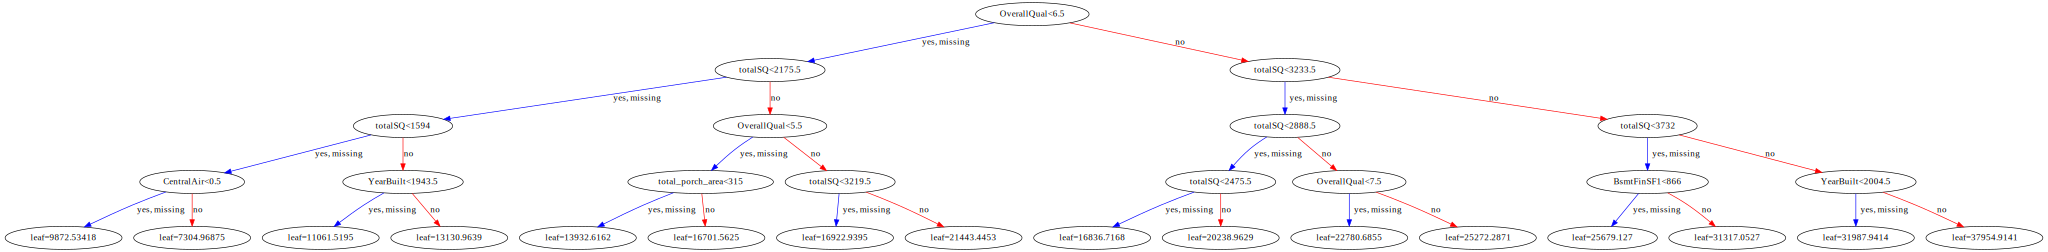

In [26]:
import graphviz
xgb.to_graphviz(xgbFinal)

# Feature Importance

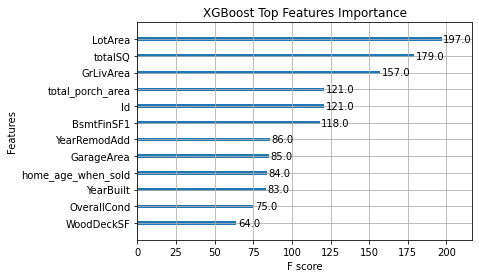

<Figure size 1440x1440 with 0 Axes>

In [27]:
xgb.plot_importance(xgbFinal, max_num_features=12, title='XGBoost Top Features Importance')
plt.figure(figsize = (20, 20))
plt.show()

In [28]:
importance=xgbFinal.feature_importances_
name=xgbFinal.feature_names_in_
print("Feature Importance:")
for num in range(len(name)):
    print(round(importance[num],4), " ", name[num])

Feature Importance:
0.0028   Id
0.0094   LotArea
0.4945   OverallQual
0.0115   OverallCond
0.013   YearBuilt
0.0225   YearRemodAdd
0.018   BsmtFinSF1
0.0216   CentralAir
0.0081   GrLivArea
0.0407   KitchenAbvGr
0.0232   Fireplaces
0.0542   GarageCars
0.0095   GarageArea
0.004   WoodDeckSF
0.1769   totalSQ
0.0496   bathrooms
0.0209   NewConstruction
0.0142   home_age_when_sold
0.0054   total_porch_area


In [29]:
#RandSearch is a good way to find what parameters are good and which ones are not:
def randSearch():
    clf_xgb = xgb.XGBRegressor()
    param_dist = {'n_estimators': stats.randint(50, 130),
                  'learning_rate': stats.uniform(0.01, 0.07),
                  'subsample': stats.uniform(0.3, 0.7),
                  'max_depth': [3, 4, 5, 6],
                  'colsample_bytree': stats.uniform(0.5, 0.45),
                  'min_child_weight': [1, 10]
                 }
    clf = RandomizedSearchCV(
        clf_xgb, param_distributions = param_dist, n_iter = 10, 
     scoring = 'r2', error_score = 0, verbose = 3, n_jobs = -1)

    numFolds = 5
    folds = KFold(n_splits = numFolds, shuffle = True)

    estimators = []
    results = np.zeros(len(X))
    score = 0.0
    for train_index, test_index in folds.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
        clf.fit(X_train, y_train)

        estimators.append(clf.best_estimator_)
        results[test_index] = clf.predict(X_test)
        score += r2_score(y_test, results[test_index])
    score /= numFolds

# Test Dataset
Make final predictions on unknown house price value using features from Train data

In [30]:
test='/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
testDF=pd.read_csv(test)
print(testDF.shape)

#Missing Values
testDF=testDF.drop_duplicates()
testDF['MiscFeature']=testDF['MiscFeature'].fillna(0)
testDF['Alley']=testDF['Alley'].fillna(0)
testDF['Fence']=testDF['Fence'].fillna(0)
testDF['FireplaceQu']=testDF['FireplaceQu'].fillna(0)
testDF=testDF.fillna(df.mean())

# Feature Engineer
testDF['totalSQ']=testDF['1stFlrSF']+testDF['2ndFlrSF']+testDF['TotalBsmtSF']
testDF['bathrooms']=testDF['FullBath']+testDF['BsmtFullBath']+(0.5 * testDF['BsmtHalfBath'])+(0.5 * testDF['HalfBath'])
testDF['CentralAir'] = testDF['CentralAir'].replace({'Y':0, 'N':1})
testDF['NewConstruction'] = (testDF['SaleType'] == 'New').astype('int64')
testDF["PoolScore"] = testDF["PoolArea"] * testDF["PoolQC"]
testDF['home_age_when_sold']=testDF['YrSold']-testDF['YearBuilt']
testDF['total_porch_area'] = testDF['WoodDeckSF'] + testDF['OpenPorchSF'] + testDF['EnclosedPorch'] + testDF['3SsnPorch'] + testDF['ScreenPorch'] 

#testDF['SaleCondition']=testDF['SaleCondition'].apply(lambda x:1 if x == 'Normal' else 0)
#testDF['Condition1']=testDF['Condition1'].apply(lambda x: 1 if x=='Norm' else 0)

testDF = testDF.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
testDF.head()

(1459, 80)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,totalSQ,bathrooms,NewConstruction,home_age_when_sold,total_porch_area
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,120,0,0,6,2010,1778.0,1.0,0,49,260
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,12500,6,2010,2658.0,1.5,0,52,429
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,3,2010,2557.0,2.5,0,13,246
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,6,2010,2530.0,2.5,0,12,396
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,144,0,0,1,2010,2560.0,2.0,0,18,226


In [31]:
testIDs=testDF['Id']
cols=X_test.columns
testDF=testDF[cols]

In [32]:
#Final Prediction
finalPred=xgbFinal.predict(testDF).round(2)
tupDF=list(zip(testIDs,finalPred))

In [33]:
output=pd.DataFrame(tupDF, columns=['Id','SalePrice']).sort_values(by='Id').reset_index(drop=True)
output.head()

,Id,SalePrice
0,1461,135014.109375
1,1462,168482.093750
2,1463,181199.875000
3,1464,193157.078125
4,1465,177578.593750


### Final Prediction

In [34]:
print(output.shape)
output.to_csv('submission.csv', index=False)
print("Output Created")

(1459, 2)
Output Created
